<a href="https://colab.research.google.com/github/ramjv/UNET-with-Semantic-Segmentation/blob/master/UNET_TGS_Salt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K

In [0]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [43]:
ids = next(os.walk("/content/images/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  24


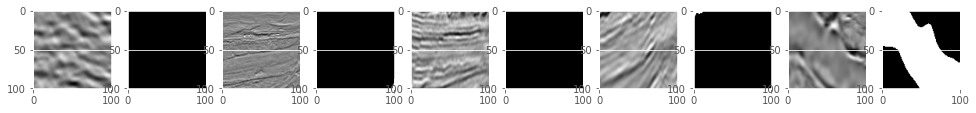

In [44]:
ids= ['000e218f21','00a3af90ab','00cda0328c','0a0814464f','0a1742c740']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('/content/images/' + img_name + '.png')
    img_mask = load_img('/content/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [0]:
X = np.zeros((len(ids), im_height, im_height, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [46]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/images/"+id_+'.png', color_mode = "grayscale")
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/content/masks/"+id_+'.png', color_mode = "grayscale"))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [0]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'Salt')

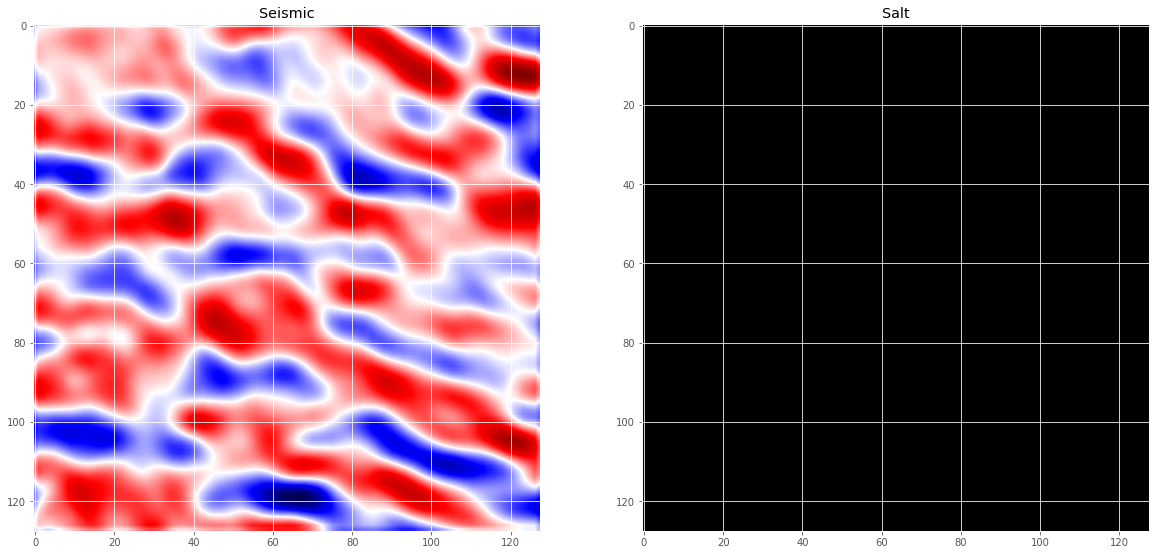

In [48]:
# Below code can be used to visualize the images and corresponding masks
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [49]:
def build_model(input_img, n_filters):
    # 128 -> 64
    conv1 = Conv2D(n_filters * 1, (3, 3), activation="relu", padding="same")(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(n_filters * 1, (3, 3), activation="relu", padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(n_filters * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(n_filters * 2, (3, 3), activation="relu", padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(n_filters * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(n_filters * 4, (3, 3), activation="relu", padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(n_filters * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(n_filters * 8, (3, 3), activation="relu", padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(n_filters * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = BatchNormalization()(convm)
    convm = Conv2D(n_filters * 16, (3, 3), activation="relu", padding="same")(convm)
    convm = BatchNormalization()(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(n_filters * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(n_filters * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(n_filters * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(n_filters * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(n_filters * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv2D(n_filters * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(n_filters * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv2D(n_filters * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

n_filters = 16

input_img = Input((im_height, im_width, 1))
output_layer = build_model(input_img, n_filters)
model = Model(input_img, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 128, 128, 16) 160         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 128, 128, 16) 64          conv2d_70[0][0]                  
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 128, 128, 16) 2320        batch_normalization_69[0][0]     
____________________________________________________________________________________________

In [50]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("model-tgs-salt.h5", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(X_train, y_train,
                    validation_data=[X_valid, y_valid], 
                    epochs=epochs,
                    batch_size=32,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 4 samples, validate on 1 samples
Epoch 1/200
4/4 [==============================] - 11s 3s/step - loss: 0.9456 - accuracy: 0.5084 - val_loss: 0.7001 - val_accuracy: 0.0270

Epoch 00001: val_loss improved from inf to 0.70012, saving model to model-tgs-salt.h5
Epoch 2/200
4/4 [==============================] - 0s 13ms/step - loss: 0.8647 - accuracy: 0.5274 - val_loss: 0.6938 - val_accuracy: 0.2618

Epoch 00002: val_loss improved from 0.70012 to 0.69378, saving model to model-tgs-salt.h5
Epoch 3/200
4/4 [==============================] - 0s 13ms/step - loss: 0.8113 - accuracy: 0.5486 - val_loss: 0.6876 - val_accuracy: 0.9955

Epoch 00003: val_loss improved from 0.69378 to 0.68759, saving model to model-tgs-salt.h5
Epoch 4/200
4/4 [==============================] - 0s 13ms/step - loss: 0.7806 - accuracy: 0.5541 - val_loss: 0.6808 - val_accuracy: 0.9969

Epoch 00004: val_loss improved from 0.68759 to 0.68077, saving model to model-tgs-salt.h5
Epoch 5/200
4/4 [======================

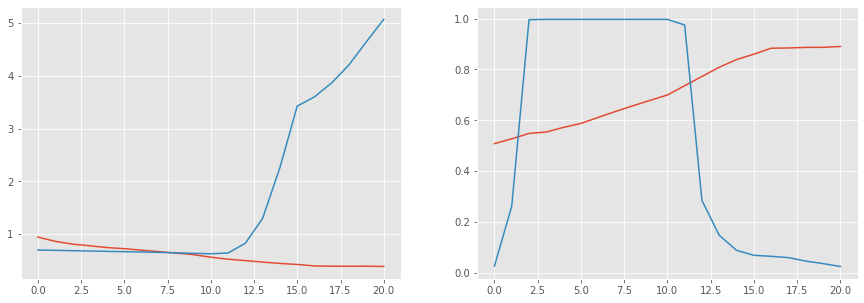

In [51]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")

In [52]:
# load the best model
model = load_model('model-tgs-salt.h5')

# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 9ms/step


In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

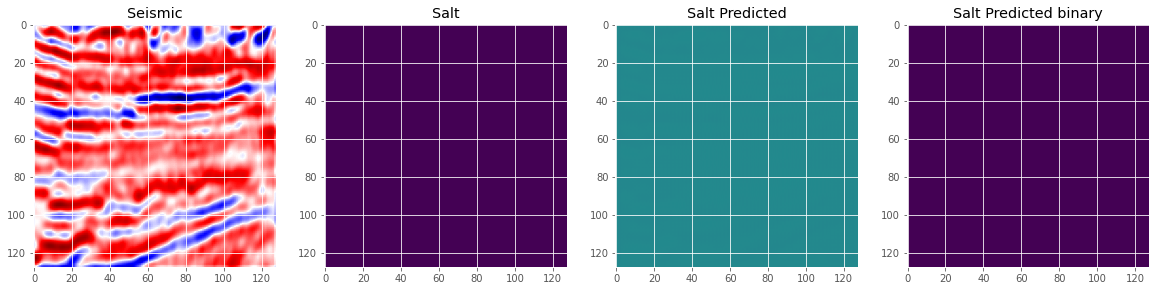

In [54]:
#Predictions on training set

# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=1)

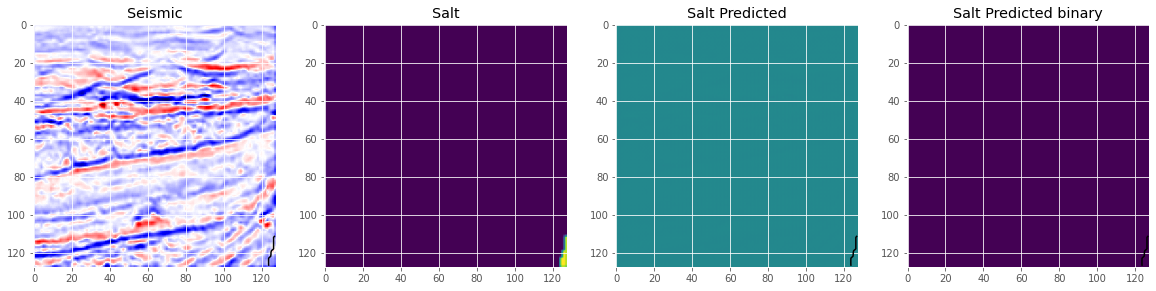

In [55]:
#Predictions on test set

# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=0)

In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


In [58]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_train, np.int32(preds_train > threshold)) for threshold in tqdm_notebook(thresholds)])
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


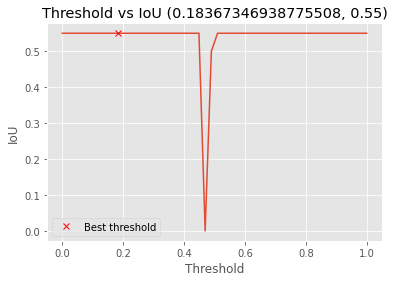

In [59]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

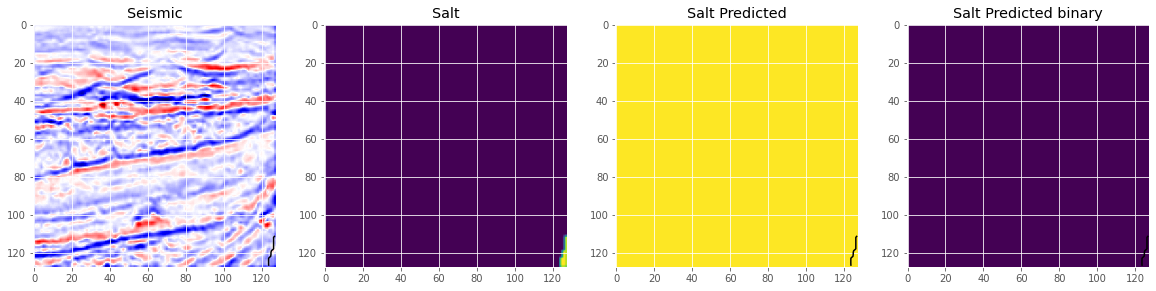

In [60]:
#Predictions on test set again some sample images with the adjusted threshold.

# Check if valid data looks all right
plot_sample(X_valid, y_valid, np.array(np.round(preds_val > threshold_best), dtype=np.float32), preds_val_t, ix=0)